# Visualisering av nedbør
Denne notebooken benytter klasser fra analyseData og visualiserer forskjellige trender i nedbør over tid
basert på forskjellige statistiske utregninger

### Felles import for alle kodeblokker

In [1]:
import calendar
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import sys

sys.path.append("../../src/analyseData")

from yearlystats import YearlyStats
from outlieranalysis import OutlierAnalysis
from outlierdetector import OutlierDetector

ys = YearlyStats("../../data/processed")
oa = OutlierAnalysis("../../data/processed")
od = OutlierDetector()

city         = "Oslo" # Kan byttes til Trosmo
element_id = "sum(precipitation_amount P1D)"
offset     = None
# Som standard velger alle funksjoner laveste timeoffset når den ikke får verdi eller står som None

print(f"All data i notebooken gjelder følgende:\nBy: {city} - Måling: {element_id} - TimeOffset: {offset}")

All data i notebooken gjelder følgende:
By: Oslo - Måling: sum(precipitation_amount P1D) - TimeOffset: None


## Total nedbørsmengde per år får Oslo og Tromsø

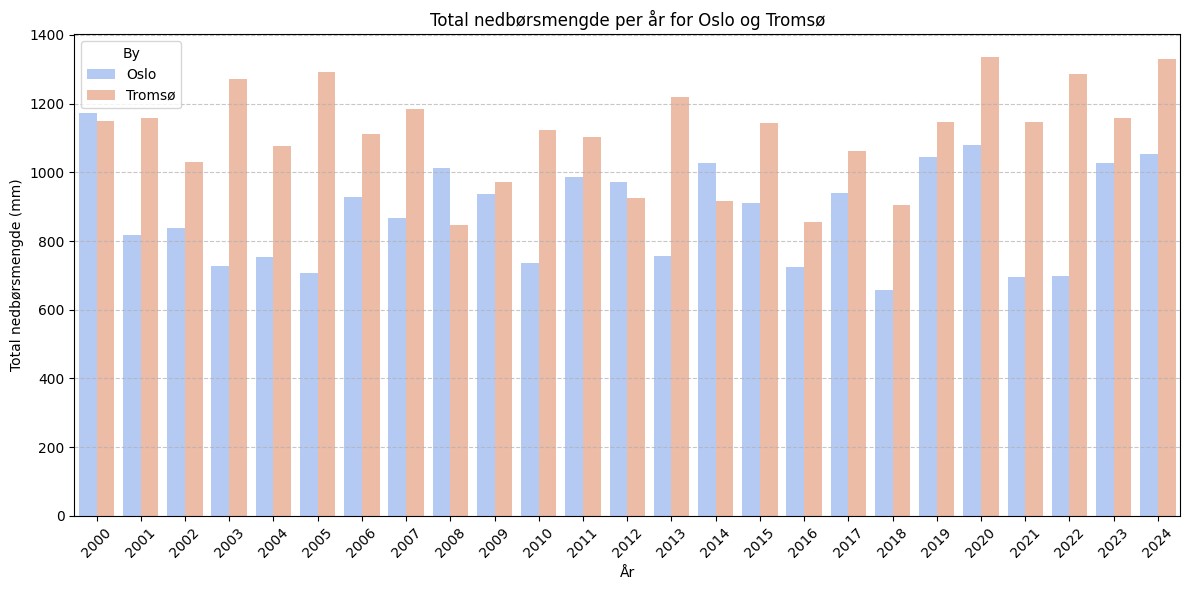

In [2]:
def yearly_precip(city: str, city_label: str) -> pd.DataFrame:
    """
    Hent årlig nedbør for én by.

    Parametre:
        city (str): Bykode, f.eks. "oslo".
        city_label (str): Navn som skal vises i DataFramen.
    """
    df = ys.compute_yearly(
        city=city,
        element_id="sum(precipitation_amount P1D)",
        aggregate="sum",
    )
    df["city"] = city_label
    return df


annual_precip = pd.concat(
    [
        yearly_precip("oslo", "Oslo"),
        yearly_precip("tromso", "Tromsø"),
    ],
    ignore_index=True,
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=annual_precip,
    x="year",
    y="value",
    hue="city",
    palette="coolwarm",
)
plt.title("Total nedbørsmengde per år for Oslo og Tromsø")
plt.xlabel("År")
plt.ylabel("Total nedbørsmengde (mm)")
plt.xticks(rotation=45)
plt.legend(title="By")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

## Visualisering for en enkelt by

### Gjennomsnittlig daglig nedbør per måned

In [3]:
df_klima = ys.climatological_monthly_mean(
    city,
    element_id,
    statistic="mean",
)

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=df_klima["month_name"],
        y=df_klima["value"],
        name=city,
    ),
)
fig.update_layout(
    title=f"Gjennomsnittlig daglig nedbør per måned ({city})",
    xaxis_title="Måneder",
    yaxis_title="Nedbør (mm)",
    template="plotly_white",
)
fig.show()

### Gjennomsnittlig nedbør per år

In [4]:
df_mean = ys.compute_yearly(
    city,
    element_id,
)

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=df_mean["year"],
        y=df_mean["value"],
        name=city,
    ),
)
fig.update_layout(
    title=f"Gjennomsnittlig daglig nedbør per år ({city})",
    xaxis=dict(
        title="År",
        tickmode="array",
        tickvals=df_mean["year"],
        ticktext=df_mean["year"],
        tickangle=45,
    ),
    yaxis_title="Nedbør (mm)",
    template="plotly_white",
)
fig.show()

### Månedlig gjennomsnitt av dager med store nedbørsmengder

In [5]:
df = oa.find_outliers_per_month(
    city=city,
    element_id=element_id,
    time_offset=offset,
    include_empty_months=True,
)

df["year_month"] = pd.to_datetime(df["year_month"])
df["month"] = df["year_month"].dt.month

mean_outliers = (
    df.groupby("month")["outliers_removed"]
    .mean()
    .reindex(range(1, 13))
)

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=[
            calendar.month_abbr[m].capitalize()
            for m in mean_outliers.index
        ],
        y=mean_outliers.values,
        name=city,
    ),
)
fig.update_layout(
    title=(
        f"Månedlig gjennomsnitt av dager med "
        f"store nedbørsmengder ({city})"
    ),
    xaxis_title="Måneder",
    yaxis_title="Antall dager",
    template="plotly_white",
)
fig.show()

### Årlig gjennomsnitt av dager med store nedbørsmengder

In [6]:
df = oa.find_outliers_per_month(
    city=city,
    element_id=element_id,
    time_offset=offset,
    include_empty_months=True,
)

df["year_month"] = pd.to_datetime(df["year_month"])
df["year"] = df["year_month"].dt.year

outliers_per_year = (
    df.groupby("year")["outliers_removed"]
    .sum()
    .reset_index()
)

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=outliers_per_year["year"],
        y=outliers_per_year["outliers_removed"],
        name=city,
    ),
)
fig.update_layout(
    title=(
        f"Årlig gjennomsnitt av dager med "
        f"store nedbørsmengder ({city})"
    ),
    xaxis_title="År",
    yaxis_title="Antall dager",
    template="plotly_white",
)
fig.show()

### Boxplot visualisering av ekstremverdier

In [7]:
year = 2005

df_year = ys.compute_yearly(
    city,
    element_id,
    year,
    aggregate=None,
)

summary = od.summarize(df_year["value"])
q1, q3, iqr = summary["Q1"], summary["Q3"], summary["IQR"]
extreme_mask = od.detect_iqr(df_year["value"], extreme=True)
core_series = od.remove_outliers_iqr(
    df_year["value"],
    extreme=True,
)
core_vals = core_series.dropna()

stats_mean = oa.stats_with_without_outliers(
    city=city,
    element_id=element_id,
    time_offset=offset,
    statistic="mean",
)
stats_median = oa.stats_with_without_outliers(
    city=city,
    element_id=element_id,
    time_offset=offset,
    statistic="median",
)

stats_mean_year = stats_mean[
    stats_mean["year_month"].str.startswith(str(year))
]
stats_median_year = stats_median[
    stats_median["year_month"].str.startswith(str(year))
]

mean_with_out = stats_mean_year["mean_with_outliers"].mean()
mean_no_out = stats_mean_year["mean_without_outliers"].mean()
median_core = stats_median_year["median_without_outliers"].mean()
extreme_vals = df_year.loc[
    extreme_mask, ["value", "referenceTime"]
]

fig = go.Figure()
fig.add_trace(
    go.Box(
        x=core_vals,
        y=[0] * len(core_vals),
        orientation="h",
        boxpoints=False,
        fillcolor="lightblue",
        line=dict(color="black"),
        width=0.9,
        hoverinfo="skip",
        showlegend=False,
    ),
)

if not extreme_vals.empty:
    fig.add_trace(
        go.Scatter(
            x=extreme_vals["value"],
            y=[0] * len(extreme_vals),
            mode="markers",
            marker=dict(color="red", size=7),
            text=extreme_vals["referenceTime"].dt.strftime("%Y-%m-%d"),
            hovertemplate=(
                "<b>%{text}</b><br>"
                "Nedbør: %{x:.1f} mm<extra></extra>"
            ),
            showlegend=False,
        ),
    )

fig.add_vline(x=mean_with_out, line_width=1, line_dash="dot", line_color="orange")
fig.add_vline(x=mean_no_out, line_width=1, line_dash="dot", line_color="green")
fig.add_vline(x=median_core, line_width=1, line_dash="dot", line_color="blue")

info = (
    f"<b>Q1:</b> {q1:.1f} mm<br>"
    f"<span style='color:blue'><b>Median uten outliers:</b></span> {median_core:.1f} mm<br>"
    f"<b>Q3:</b> {q3:.1f} mm<br>"
    f"<b>IQR:</b> {iqr:.1f} mm<br><br>"
    f"<span style='color:orange'><b>Mean inkl. outliers:</b></span> {mean_with_out:.1f} mm<br>"
    f"<span style='color:green'><b>Mean ekskl. outliers:</b></span> {mean_no_out:.1f} mm<br><br>"
    f"<span style='color:red'><b>Røde punkter</b></span>: > 3 × IQR<br>"
    f"{len(extreme_vals)} ekstreme målinger<br><br>"
)

fig.add_annotation(
    xref="paper",
    yref="paper",
    x=1,
    y=1.25,
    xanchor="right",
    yanchor="top",
    text=info,
    showarrow=False,
    align="left",
    bordercolor="lightgrey",
    borderwidth=1,
    bgcolor="white",
    font=dict(size=12),
)

fig.update_layout(
    title=(
        f"Daglig nedbør – boxplot med ekstreme outliers – "
        f"{city.capitalize()} {year}"
    ),
    xaxis_title="Nedbør (mm)",
    yaxis=dict(visible=False, range=[-1, 1]),
    template="plotly_white",
    hovermode="x",
)

fig.show()